In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
import joblib

In [12]:
stock_data = pd.read_csv('/Users/sachinkarthikeya/Desktop/Projects/SPP-LSTM/bse_stock_data.csv')
stock_data['date'] = pd.to_datetime(stock_data['date'])
stock_data.set_index('date', inplace=True)

In [13]:
stock_data['20_MA'] = stock_data['close'].rolling(window=20).mean()
stock_data['50_MA'] = stock_data['close'].rolling(window=50).mean()
stock_data.dropna(inplace=True)

In [14]:
company_ids = stock_data['Symbol'].astype('category').cat.codes
stock_data['Symbol_encoded'] = company_ids

In [28]:
print(stock_data.head())


              open     high      low    close    volume    Company  \
date                                                                 
2024-09-16  1660.6  1677.65  1660.60  1671.00  426415.0  HDFC Bank   
2024-09-13  1672.0  1674.00  1657.15  1665.35  445093.0  HDFC Bank   
2024-09-12  1648.3  1669.50  1647.35  1666.00  564550.0  HDFC Bank   
2024-09-11  1650.0  1652.20  1639.10  1644.35  230766.0  HDFC Bank   
2024-09-10  1652.4  1654.00  1638.00  1650.60  287723.0  HDFC Bank   

                  Symbol      20_MA     50_MA  Symbol_encoded  
date                                                           
2024-09-16  HDFCBANK.BSE  1701.4425  1720.677               1  
2024-09-13  HDFCBANK.BSE  1700.2850  1717.764               1  
2024-09-12  HDFCBANK.BSE  1701.0725  1715.376               1  
2024-09-11  HDFCBANK.BSE  1700.1750  1712.571               1  
2024-09-10  HDFCBANK.BSE  1701.0200  1710.664               1  


In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(stock_data[['close', 'volume', '20_MA', '50_MA']])

In [16]:
scaled_data = np.hstack([scaled_features, company_ids.values.reshape(-1, 1)])

In [18]:
lookback = 90
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i])
    y.append(scaled_data[i, 0])  

X, y = np.array(X), np.array(y)

In [19]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [20]:
model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(100, return_sequences=False)),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


695/695 ━━━━━━━━━━━━━━━━━━━━ 119s 169ms/step - loss: 0.0037 - val_loss: 4.7567e-04
Epoch 2/100
695/695 ━━━━━━━━━━━━━━━━━━━━ 132s 190ms/step - loss: 5.8320e-04 - val_loss: 2.4172e-04
Epoch 3/100
695/695 ━━━━━━━━━━━━━━━━━━━━ 120s 173ms/step - loss: 4.7839e-04 - val_loss: 4.9163e-04
Epoch 4/100
695/695 ━━━━━━━━━━━━━━━━━━━━ 116s 166ms/step - loss: 3.0720e-04 - val_loss: 3.0396e-04
Epoch 5/100
695/695 ━━━━━━━━━━━━━━━━━━━━ 115s 166ms/step - loss: 2.8334e-04 - val_loss: 1.2879e-04
Epoch 6/100
695/695 ━━━━━━━━━━━━━━━━━━━━ 121s 174ms/step - loss: 3.4253e-04 - val_loss: 1.6278e-04
Epoch 7/100
695/695 ━━━━━━━━━━━━━━━━━━━━ 122s 175ms/step - loss: 2.0772e-04 - val_loss: 3.1519e-04
Epoch 8/100
695/695 ━━━━━━━━━━━━━━━━━━━━ 122s 175ms/step - loss: 3.8630e-04 - val_loss: 1.9329e-04
Epoch 9/100
695/695 ━━━━━━━━━━━━━━━━━━━━ 121s 174ms/step - loss: 2.4714e-04 - val_loss: 1.0601e-04
Epoch 10/100
695/695 ━━━━━━━━━━━━━━━━━━━━ 117s 168ms/step - loss: 2.1197e-04 - val_loss: 7.2203e-05
Epoch 11/100
695/695 ━━━━

In [21]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.concatenate([predicted_prices, np.zeros((predicted_prices.shape[0], 3))], axis=1))[:, 0]

218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step


In [22]:
y_test_scaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3))], axis=1))[:, 0]

mse = mean_squared_error(y_test_scaled, predicted_prices)
mae = mean_absolute_error(y_test_scaled, predicted_prices)
r2 = r2_score(y_test_scaled, predicted_prices)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-square Error (R2): {r2}")

Mean Squared Error (MSE): 5957.709342651439
Mean Absolute Error (MAE): 35.60026396565442
R-square Error (R2): 0.9915297582175816


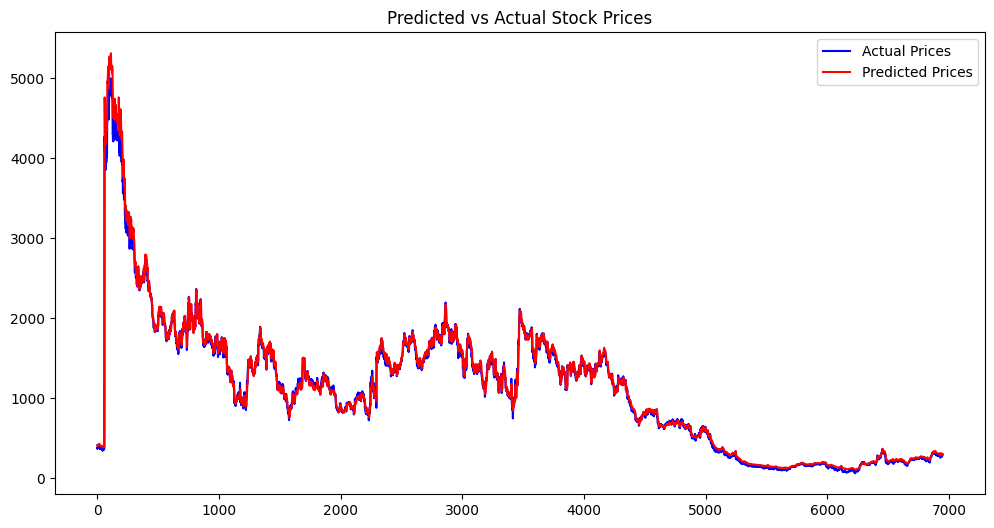

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='red')
plt.title('Predicted vs Actual Stock Prices')
plt.legend()
plt.show()

In [24]:
model.save("stock_prediction_model.h5")

In [25]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [29]:
stock_data.to_csv('preprocessed_stock_data.csv', index=False)